
# Recurrent PPO (LSTM) for Next‑Day Direction on TSLA

We train a **Recurrent PPO** agent (LSTM policy) to predict whether **tomorrow's close** is **up or down** relative to today.
- **Action**: `0 = down`, `1 = up`
- **Reward**: `+1` if correct, `−1` if incorrect, `0` if unchanged
- **Why LSTM?**: Markets exhibit temporal dependencies (momentum/mean‑reversion). LSTM maintains memory across days.

> Educational use only. Not financial advice.


In [8]:

# !pip install stable-baselines3 sb3-contrib gymnasium pandas numpy matplotlib scikit-learn --quiet
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.monitor import Monitor
from sklearn.preprocessing import StandardScaler

from sb3_contrib import RecurrentPPO

np.random.seed(7)



## 1) Load TSLA data (CSV preferred; synthetic fallback)
Expected CSV columns: `Date, Open, High, Low, Close, Volume`.


In [9]:

DATA_PATH = '/mnt/data/TSLA.csv'

def generate_synth(n_days=2500, s0=30.0, mu=0.22, sigma=0.55):
    dt = 1/252
    prices = [s0]
    cur_sigma = sigma
    for t in range(1, n_days):
        if np.random.rand() < 0.004:
            cur_sigma = np.clip(cur_sigma * np.random.uniform(0.7, 1.3), 0.15, 0.9)
        z = np.random.randn()
        ret = (mu - 0.5 * cur_sigma**2) * dt + cur_sigma * math.sqrt(dt) * z
        prices.append(prices[-1] * math.exp(ret))
    close = np.array(prices)
    open_ = np.concatenate([[close[0]], close[:-1]])
    high = np.maximum(open_, close) * (1 + np.random.rand(len(close))*0.01)
    low  = np.minimum(open_, close) * (1 - np.random.rand(len(close))*0.01)
    vol  = np.random.randint(2_000_000, 40_000_000, size=len(close)).astype(float)
    dates = pd.bdate_range('2012-01-03', periods=len(close))
    return pd.DataFrame({'Date': dates, 'Open': open_, 'High': high, 'Low': low, 'Close': close, 'Volume': vol})

if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH, parse_dates=['Date'])
    print('Loaded TSLA.csv from /mnt/data. Rows:', len(df))
else:
    print('WARNING: /mnt/data/TSLA.csv not found. Using synthetic data so the notebook can run.')
    df = generate_synth()
    print('Synthetic rows:', len(df))

df = df.sort_values('Date').reset_index(drop=True)
df.head()


Synthetic rows: 2500


,Date,Open,High,Low,Close,Volume
0,2012-01-03,30.000000,30.133452,29.879599,30.000000,32933098.0
1,2012-01-04,30.000000,30.162295,29.467511,29.676703,26144627.0
2,2012-01-05,29.676703,31.480524,29.663881,31.221856,11962423.0
3,2012-01-06,31.221856,31.399940,31.159727,31.331346,15734720.0
4,2012-01-09,31.331346,35.357421,31.297380,35.015582,9638783.0



## 2) Features and Directional Target
- Features: recent returns, volatility, RSI
- Target: `dir_{t+1} = 1 if Close[t+1] > Close[t] else 0` (binary UP/DOWN)


In [10]:

def make_features(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    out['logret'] = np.log(out['Close']).diff().fillna(0.0)
    out['ret1'] = out['Close'].pct_change(1).fillna(0.0)
    out['ret5'] = out['Close'].pct_change(5).fillna(0.0)
    out['vol20'] = out['logret'].rolling(20).std().fillna(0.0)

    # RSI(14)
    delta = out['Close'].diff().fillna(0.0)
    gain = delta.clip(lower=0.0)
    loss = -delta.clip(upper=0.0)
    roll = 14
    avg_gain = gain.rolling(roll).mean().fillna(0.0)
    avg_loss = loss.rolling(roll).mean().fillna(1e-6)
    rs = avg_gain / avg_loss
    out['rsi14'] = 100 - (100 / (1 + rs))

    # Target: next-day direction
    close = out['Close'].values
    nxt = np.roll(close, -1)
    direction = (nxt > close).astype(np.int32)
    out['target_dir'] = direction
    out.iloc[-1, out.columns.get_loc('target_dir')] = out['target_dir'].iloc[-2]  # pad last
    
    out = out.replace([np.inf, -np.inf], 0.0).fillna(0.0)
    return out

feat_df = make_features(df)
feat_cols = ['ret1', 'ret5', 'vol20', 'rsi14', 'logret']
target_col = 'target_dir'

# 80/20 split by time
split_idx = int(len(feat_df) * 0.8)
train_df = feat_df.iloc[:split_idx].copy()
test_df  = feat_df.iloc[split_idx:].copy()

X_train = train_df[feat_cols].values.astype(np.float32)
X_test  = test_df[feat_cols].values.astype(np.float32)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

y_train = train_df[target_col].values.astype(np.int64)
y_test  = test_df[target_col].values.astype(np.int64)

dates_train = train_df['Date'].values
dates_test  = test_df['Date'].values

print('Train rows:', len(train_df), ' Test rows:', len(test_df), ' Split date:', str(test_df['Date'].iloc[0].date()))


Train rows: 2000  Test rows: 500  Split date: 2019-09-03



## 3) Sequential Environment (Discrete Direction Prediction)


In [11]:

from dataclasses import dataclass
import gymnasium as gym
from gymnasium import spaces
import numpy as np

@dataclass
class DirEnvCfg:
    include_last_action: bool = True
    reward_for_flat: int = 0  # only used if you encode flats

class DirectionEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    def __init__(self, X, y, cfg: DirEnvCfg):
        super().__init__()
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.cfg = cfg

        obs_dim = self.X.shape[1] + (1 if cfg.include_last_action else 0)
        self.observation_space = spaces.Box(low=-10, high=10, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0=down, 1=up

        self.t = 0
        self.last_action = 1  # start "up"

    def _obs(self):
        if self.cfg.include_last_action:
            return np.concatenate([self.X[self.t], np.array([self.last_action], dtype=np.float32)])
        return self.X[self.t]

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.last_action = 1
        return self._obs(), {}

    def step(self, action):
        action = int(action)
        target = int(self.y[self.t])
        reward = +1.0 if action == target else -1.0

        self.last_action = action
        self.t += 1
        terminated = (self.t >= len(self.X) - 1)
        truncated = False
        obs = self._obs() if not terminated else self._obs()
        info = {'target': target, 'correct': float(reward > 0)}
        return obs, reward, terminated, truncated, info

    def render(self):
        pass


# Q1

*In your own words, describe how the DirectionEnv differs from a standard supervised-learning dataset. Include what the agent sees, decides, and receives as feedback at each timestep.*

The agent sees the price of the stock at time `t` and the last action it took (up or down). In the `step` function, the agent is deciding if the stock went up up (1) or down (0). As feedback the agent receives a reward of +1 if it correctly predicts up or down, and -1 otherwise. 

This differs from a standard supervised-learning dataset in a few ways. First, the agent is not predicting what the subsequent value will be, instead it is just predicting if the price will rise or fall. Second, in a supervised-learning environment the agent is shown the ground truth and can use the difference between its prediction and the actual value to perform a gradient descent. In this RL environment, the agent is tuning its behavior based on the feedback from the reward (-1 or +1). Finally, the data is presented sequentially and in an episodic fashion whereas in traditional supervised-learning contexts the training data is sampled from randomly. Additionally, the previous response from the agent is presented in the next observation, which would not be a part of the observation space in a supervised context. 

# Q2

*Why does the notebook use a Recurrent (LSTM) policy rather than a simple MLP?*

 


## 4) Vectorized Envs and Recurrent PPO


In [12]:

from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.monitor import Monitor

train_env_cfg = DirEnvCfg(include_last_action=True, reward_for_flat=0)
test_env_cfg  = DirEnvCfg(include_last_action=True, reward_for_flat=0)

def make_env(X, y, cfg):
    def _init():
        return Monitor(DirectionEnv(X, y, cfg))
    return _init

env_train = DummyVecEnv([make_env(X_train, y_train, train_env_cfg)])
env_train = VecMonitor(env_train)

env_test  = DummyVecEnv([make_env(X_test, y_test, test_env_cfg)])
env_test  = VecMonitor(env_test)


/home/chandler/Documents/ece6930-004/torchenv/lib/python3.13/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(



## 5) Train


In [13]:

from sb3_contrib import RecurrentPPO

model = RecurrentPPO(
    policy='MlpLstmPolicy',
    env=env_train,
    learning_rate=2.5e-4,
    n_steps=512,
    batch_size=128,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.01,
    clip_range=0.15,
    vf_coef=0.5,
    seed=0,
    verbose=1,
)
model.learn(total_timesteps=200_000)


Using cuda device
----------------------------
| time/              |     |
|    fps             | 324 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 162           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00033284957 |
|    clip_fraction        | 0             |
|    clip_range           | 0.15          |
|    entropy_loss         | -0.693        |
|    explained_variance   | -0.00471      |
|    learning_rate        | 0.00025       |
|    loss                 | 4.9           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00097      |
|    value_loss           | 7.98          |
-------------------------------


## 6) Evaluate (Directional Accuracy)


In [14]:

obs = env_test.reset()
lstm_states = None
episode_starts = np.ones((env_test.num_envs,), dtype=bool)

done = False
preds = []
trues = []
acc_path = []
correct = 0
count = 0

while not done:
    action, lstm_states = model.predict(
        obs,
        state=lstm_states,
        episode_start=episode_starts,
        deterministic=True
    )
    obs, rewards, dones, infos = env_test.step(action)
    info0 = infos[0]
    trues.append(int(info0['target']))
    preds.append(int(action[0]))
    correct += int(info0['target'] == int(action[0]))
    count += 1
    acc_path.append(correct / max(1, count))

    episode_starts = dones
    done = bool(dones[0])

accuracy = correct / max(1, count)
print(f"Directional accuracy on test: {accuracy:.3f}")


Directional accuracy on test: 0.511



## 7) Plots


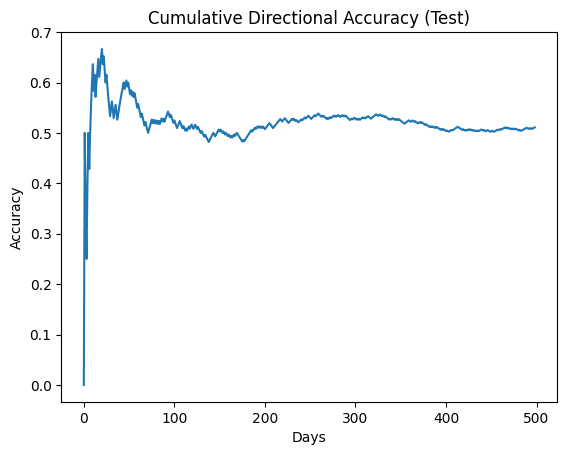

In [15]:

import matplotlib.pyplot as plt
plt.figure()
plt.plot(acc_path)
plt.title('Cumulative Directional Accuracy (Test)')
plt.xlabel('Days')
plt.ylabel('Accuracy')
plt.show()


In [16]:

from collections import Counter
pairs = list(zip(trues, preds))
cm = Counter(pairs)
labels = [(0,0), (0,1), (1,0), (1,1)]
print("Confusion counts (true, pred):")
for k in labels:
    print(f"{k}: {cm.get(k, 0)}")


Confusion counts (true, pred):
(0, 0): 119
(0, 1): 127
(1, 0): 117
(1, 1): 136
